# Exercise 06 - Shape optimization of trusses

Shape optimization means that given a fixed topology of a truss, we want optimize its stiffness by modifying some node positions. In this particular example, we investigate the optimal shape of a railway bridge like in the photograph here:

![Bridge](figures/bridge.jpeg)


In [17]:
from math import sqrt
import torch
import matplotlib.pyplot as plt
from simple_truss import Truss

torch.set_default_dtype(torch.double)

So let's start by defining the base truss topology of the bridge without considering the exact shape for now. We create a simple rectangular bridge that has all the bars seen in the photo. The truss is fixed at the bottom left side and simply supported at the bottom right side. The load is distributed along the bottom edge of the bridge, which represents the train track.

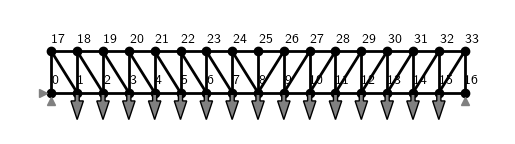

In [18]:
# Dimensions
A = 17
B = 2

# Nodes
n1 = torch.linspace(0.0, 5.0, A)
n2 = torch.linspace(0.0, 0.5, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Elements
elements = []
for i in range(A - 1):
    for j in range(B):
        elements.append([i + j * A, i + 1 + j * A])
for i in range(A):
    for j in range(B - 1):
        elements.append([i + j * A, i + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        if i >= (A - 1) / 2:
            elements.append([i + j * A, i + 1 + A + j * A])
        else:
            elements.append([i + 1 + j * A, i + A + j * A])

# Forces at bottom edge
forces = torch.zeros_like(nodes)
forces[1 : A - 1, 1] = -0.1

# Constraints by the supports
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[A - 1, 1] = True

# Areas
areas = torch.ones((len(elements)))

# Truss
bridge = Truss(nodes.clone(), elements, forces, constraints, areas, E=500.0)
bridge.plot()

## Task 1 - Preparation of design variables

We want to restrict the shape optimization problem to the vertical displacement of the top nodes. Other nodes should not be modified - the train track should remain a flat line.

a) Create a boolean tensor `mask` of the same shape as `nodes`. It should be `True` for the vertical degree of freedom of the top nodes and `False` for every other degree of freedom. Essentially it should mask out those nodal degrees of freedom which should be optimized.

b) Create initial values `x_0` of the masked top node positions. Set limits to the deformation (`x_min`, `x_max`) such that nodes can move down by 0.4 and up by 0.5 units.

c) Compute the current volume of the truss `V0`. We will use this as a constraint in the optimization problem such that the optimized solution does not exceed this initial volume.

In [19]:
# Mask for design variables.
mask = torch.zeros_like(nodes, dtype=bool)
mask[A : 2 * A, 1] = True

# Limits on design variables
x_0 = nodes[mask].ravel()
x_min = x_0 - 0.4
x_max = x_0 + 0.5

# Compute current volume
l = bridge.element_lengths()
V0 = torch.inner(areas, l)

## Task 2 - Optimization

You are provided with the `box_constrained_decent` function for minimization and `MMA` function for approximation from previous exercises. Using these, you should write a function `optimize(truss, x_0, x_min, x_max, V_0, mask, iter)` that takes a `truss` and optimizes its (masked) nodal positions `x` such that it minimizes the compliance using a maximum volume `V_0`. The function should return a list $\mathbf{x}^0, \mathbf{x}^1, \mathbf{x}^2, ...$ containing the iteration steps of the optimization procedure. 

In [20]:
def box_constrained_decent(func, x_init, x_lower, x_upper, eta=0.1, max_iter=100):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.max(torch.min(x, x_upper), x_lower)
    return x

In [21]:
def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    f_k = func(x_k)

    def approximation(x):
        res = f_k * torch.ones_like(x[..., 0])
        for j, grad in enumerate(grads):
            if grad < 0.0:
                p = 0
                q = -((x_k[j] - L_k[j]) ** 2) * grad
            else:
                p = (U_k[j] - x_k[j]) ** 2 * grad
                q = 0
            res -= p / (U_k[j] - x_k[j]) + q / (x_k[j] - L_k[j])
            res += p / (U_k[j] - x[..., j]) + q / (x[..., j] - L_k[j])
        return res

    return approximation, grads

In [22]:
def optimize(truss, x_0, x_min, x_max, V_0, mask, iter):
    s = 0.7

    # Set up lists for L, U, x
    L = []
    U = []
    x = [x_0]

    # Define the initial value, lower bound, and upper bound of "mu"
    mu_0 = torch.tensor([0.01])
    mu_lower = torch.tensor([1e-10])
    mu_upper = torch.tensor([100.0])

    def f(x):
        # Update nodes
        truss.nodes[mask] = x.reshape(truss.nodes[mask].shape)
        # Solve truss with updated nodes
        u_k, f_k, _ = truss.solve()
        # Return compliance
        return torch.inner(f_k.ravel(), u_k.ravel())

    def g(x):
        # Update nodes
        truss.nodes[mask] = x.reshape(truss.nodes[mask].shape)
        # Return constraint function
        return torch.inner(truss.areas, truss.element_lengths()) - V_0

    for k in range(iter):
        # Update asymptotes with heuristic procedure (see Exercise 04)
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + s * (U[k - 1][j] - x[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1.0 / sqrt(s) * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + 1.0 / sqrt(s) * (U[k - 1][j] - x[k - 1][j])
            L.append(L_k)
            U.append(U_k)
        else:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.minimum(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function and save gradients
        f_tilde, f_grad = MMA(f, x[k], L[k], U[k])
        g_tilde, g_grad = MMA(g, x[k], L[k], U[k])

        # Define the Lagrangian
        def lagrangian(x, mu):
            return f_tilde(x) + mu * g_tilde(x)

        # Define x_star by minimizing the Lagrangian w. r. t. x analytically
        def x_star(mu):
            x_hat = torch.zeros_like(f_grad)
            for i, (dfdx, dgdx) in enumerate(zip(f_grad, g_grad)):
                if dfdx > 0.0 and dgdx > 0.0:
                    x_hat[i] = x_min[i]
                if dfdx < 0.0 and dgdx < 0.0:
                    x_hat[i] = x_max[i]
                if dfdx > 0.0 and dgdx < 0.0:
                    root = torch.sqrt(
                        (-mu * dgdx * (x[k][i] - L[k][i]) ** 2)
                        / (U[k][i] - x[k][i]) ** 2
                        / dfdx
                    )
                    x_hat[i] = (U[k][i] * root + L[k][i]) / (1 + root)
                if dfdx < 0.0 and dgdx > 0.0:
                    root = torch.sqrt(
                        (-mu * dgdx * (U[k][i] - x[k][i]) ** 2)
                        / (x[k][i] - L[k][i]) ** 2
                        / dfdx
                    )
                    x_hat[i] = (U[k][i] + L[k][i] * root) / (1 + root)
            return torch.max(torch.min(x_hat, x_max_k), x_min_k)

        # Define (-1 times) the dual function
        def dual_function(mu):
            return -lagrangian(x_star(mu), mu)

        # Compute the maximum of the dual function
        mu_star = box_constrained_decent(
            dual_function, mu_0, mu_lower, mu_upper, eta=0.001
        )

        # Compute current optimal point with dual solution
        x.append(x_star(mu_star))

    return x

In [23]:
x_opt = optimize(bridge, x_0, x_min, x_max, V0, mask, iter=50)

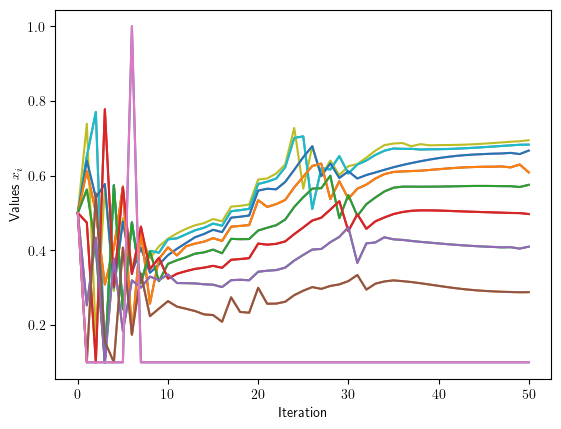

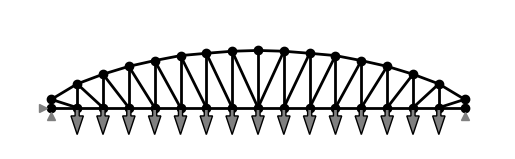

In [24]:
# Plot the development of design variables
plt.plot(torch.stack(x_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $x_i$")
plt.show()

# Plot the optimized bridge
bridge.plot(node_labels=False)